In [185]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [46]:
labels_gold = pd.read_excel('../data/phases/phases_gold.xlsx')
labels = pd.read_excel('../data/phases/phases.xlsx')

/home/kchen/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [47]:
labels_gold.head()

,vid_id,phase,time_start,time_end,labeler,notes
0,vid_0,oob,00H:00m:00s,00H:03m:15s,tf,NaN
1,vid_0,exposure,00H:03m:15s,00H:08m:46s,tf,NaN
2,vid_0,hiatal_dissec,00H:08m:46s,00H:15m:04s,tf,NaN
3,vid_0,sac_reduction,00H:15m:04s,00H:15m:37s,tf,NaN
4,vid_0,hiatal_dissec,00H:15m:37s,00H:16m:14s,tf,NaN


In [48]:
#find rows where the length of the string in 'time_start' is not 11, and delete the 5th character in the string
for i in range(len(labels_gold)):
    if len(labels_gold['time_start'][i]) != 11:
        labels_gold['time_start'][i] = labels_gold['time_start'][i][:4] + labels_gold['time_start'][i][5:]
        labels_gold['time_end'][i] = labels_gold['time_end'][i][:4] + labels_gold['time_end'][i][5:]
labels_gold.to_csv('../data/phases/phases_gold.csv', index=False)

In [ ]:
#hand processing occured here

In [149]:
labels_gold = pd.read_csv('../data/phases/phases_gold.csv')

In [150]:
labels_gold['vid_id'].value_counts()

vid_1    41
vid_0    32
vid_4    19
vid_5    18
Name: vid_id, dtype: int64

In [151]:
#keep only the vid_id's that are in both datasets
labels = labels[labels['vid_id'].isin(labels_gold['vid_id'])]
print(labels.shape)

(121, 12)


In [152]:
#time is in the form XXH:XXm:XXs, so we need to convert it to seconds
def convert_time(time):
    hours = int(time[0:2])
    mins = int(time[4:6])
    secs = int(time[8:10])
    return hours*3600 + mins*60 + secs

In [153]:
#find rows in phase gold where time_end is not 11 characters long
for i in range(len(labels_gold)):
    if len(labels_gold['time_end'][i]) != 11:
        print(i)
        print(labels_gold['time_end'][i])

In [154]:
frames_gold = pd.DataFrame(columns=['vid_id', 'phase', 'second'])

In [155]:
frames = pd.DataFrame(columns=['vid_id', 'phase', 'second'])

In [156]:
#for each vid_id, for each second, create a row with the phase
for vid_id in labels_gold['vid_id'].unique():
    vid = labels_gold[labels_gold['vid_id'] == vid_id]
    for i in range(vid.shape[0]):
        start = convert_time(vid['time_start'].iloc[i])
        end = convert_time(vid['time_end'].iloc[i])
        for second in range(start, end):
            frames_gold = frames_gold.append({'vid_id': vid_id, 'phase': vid['phase'].iloc[i], 'second': second}, ignore_index=True)
frames_gold.head()

,vid_id,phase,second
0,vid_0,oob,0
1,vid_0,oob,1
2,vid_0,oob,2
3,vid_0,oob,3
4,vid_0,oob,4


In [157]:
#same process for the other dataset
for vid_id in labels['vid_id'].unique():
    vid = labels[labels['vid_id'] == vid_id]
    for i in range(vid.shape[0]):
        start = convert_time(vid['time_start'].iloc[i])
        end = convert_time(vid['time_end'].iloc[i])
        for second in range(start, end):
            frames = frames.append({'vid_id': vid_id, 'phase': vid['phase'].iloc[i], 'second': second}, ignore_index=True)
frames.head()

,vid_id,phase,second
0,vid_0,oob,0
1,vid_0,oob,1
2,vid_0,oob,2
3,vid_0,oob,3
4,vid_0,oob,4


In [158]:
#delete duplicate rows, where vid_id and second are the same
frames_gold = frames_gold.drop_duplicates(subset=['vid_id', 'second'])
frames = frames.drop_duplicates(subset=['vid_id', 'second'])
print(frames_gold.shape, frames.shape)

(22174, 3) (22092, 3)


In [159]:
#create a new column, with vid_id and second as a unique identifier
frames_gold['id'] = frames_gold['vid_id'] + '_' + frames_gold['second'].astype(str)
frames['id'] = frames['vid_id'] + '_' + frames['second'].astype(str)

In [160]:
#rename the phase column to phase_gold
frames_gold = frames_gold.rename(columns={'phase': 'phase_gold'})
#merge the two datasets, on the id column, keeping phase and phase_gold
frames.set_index('id', inplace=True)
frames_gold.set_index('id', inplace=True)
frames_merge = frames.merge(frames_gold, left_index=True, right_index=True, how='outer')
frames_merge.head()

,vid_id_x,phase,second_x,vid_id_y,phase_gold,second_y
id,,,,,,
vid_0_0,vid_0,oob,0,vid_0,oob,0
vid_0_1,vid_0,oob,1,vid_0,oob,1
vid_0_10,vid_0,oob,10,vid_0,oob,10
vid_0_100,vid_0,oob,100,vid_0,oob,100
vid_0_1000,vid_0,hiatal_dissec,1000,vid_0,sac_reduction,1000


In [161]:
frames_merge = frames_merge[['phase', 'phase_gold']]
frames_merge.head()

,phase,phase_gold
id,,
vid_0_0,oob,oob
vid_0_1,oob,oob
vid_0_10,oob,oob
vid_0_100,oob,oob
vid_0_1000,hiatal_dissec,sac_reduction


In [162]:
#drop rows where phase_gold is NaN or phase is NaN
frames_merge = frames_merge.dropna()
frames_merge.head()

,phase,phase_gold
id,,
vid_0_0,oob,oob
vid_0_1,oob,oob
vid_0_10,oob,oob
vid_0_100,oob,oob
vid_0_1000,hiatal_dissec,sac_reduction


In [163]:
frames_merge.shape

(21737, 2)

In [164]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

In [165]:
ab_labels = labels[labels['labeler'] == 'AB']
ab_labels.shape

(11, 12)

In [166]:
mm_labels = labels[labels['labeler'] == 'mm']
mm_labels.shape

(12, 12)

In [167]:
kc_labels = labels[labels['labeler'] == 'kc']
kc_labels.shape

(75, 12)

In [168]:
#calculate the interrater reliability for AB and mm vs phase_gold
ab_frames = pd.DataFrame(columns=['vid_id', 'phase', 'second'])
mm_frames = pd.DataFrame(columns=['vid_id', 'phase', 'second'])
kc_frames = pd.DataFrame(columns=['vid_id', 'phase', 'second'])

for label_df in [ab_labels, mm_labels, kc_labels]:
    for vid_id in label_df['vid_id'].unique():
        vid = label_df[label_df['vid_id'] == vid_id]
        for i in range(vid.shape[0]):
            start = convert_time(vid['time_start'].iloc[i])
            end = convert_time(vid['time_end'].iloc[i])
            for second in range(start, end):
                if label_df['labeler'].iloc[0] == 'AB':
                    ab_frames = ab_frames.append({'vid_id': vid_id, 'phase': vid['phase'].iloc[i], 'second': second}, ignore_index=True)
                elif label_df['labeler'].iloc[0] == 'mm':
                    mm_frames = mm_frames.append({'vid_id': vid_id, 'phase': vid['phase'].iloc[i], 'second': second}, ignore_index=True)
                else:
                    kc_frames = kc_frames.append({'vid_id': vid_id, 'phase': vid['phase'].iloc[i], 'second': second}, ignore_index=True)


In [169]:
ab_frames

,vid_id,phase,second
0,vid_4,oob,0
1,vid_4,oob,1
2,vid_4,oob,2
3,vid_4,oob,3
4,vid_4,oob,4
...,...,...,...
4065,vid_4,other,4065
4066,vid_4,other,4066
4067,vid_4,other,4067
4068,vid_4,other,4068


In [170]:
print(ab_frames.shape, mm_frames.shape, kc_frames.shape)

(4070, 3) (4195, 3) (22080, 3)


In [171]:
ab_frames['id'] = ab_frames['vid_id'] + '_' + ab_frames['second'].astype(str)
mm_frames['id'] = mm_frames['vid_id'] + '_' + mm_frames['second'].astype(str)
kc_frames['id'] = kc_frames['vid_id'] + '_' + kc_frames['second'].astype(str)
ab_frames.set_index('id', inplace=True)
mm_frames.set_index('id', inplace=True)
kc_frames.set_index('id', inplace=True)
ab_frames = ab_frames.merge(frames_gold, left_index=True, right_index=True, how='outer')
mm_frames = mm_frames.merge(frames_gold, left_index=True, right_index=True, how='outer')
kc_frames = kc_frames.merge(frames_gold, left_index=True, right_index=True, how='outer')
ab_frames = ab_frames[['phase', 'phase_gold']]
mm_frames = mm_frames[['phase', 'phase_gold']]
kc_frames = kc_frames[['phase', 'phase_gold']]
ab_frames = ab_frames.dropna()
mm_frames = mm_frames.dropna()
kc_frames = kc_frames.dropna()


In [172]:
res_df = pd.DataFrame(columns=['phase', 'ab_accuracy', 'mm_accuracy', 'kc_accuracy'])

In [173]:
for phase in frames_merge['phase_gold'].unique():
    phase_df = ab_frames[ab_frames['phase_gold'] == phase]
    ab_accuracy = accuracy_score(phase_df['phase_gold'], phase_df['phase'])    
    phase_df = mm_frames[mm_frames['phase_gold'] == phase]
    mm_accuracy = accuracy_score(phase_df['phase_gold'], phase_df['phase'])
    phase_df = kc_frames[kc_frames['phase_gold'] == phase]
    kc_accuracy = accuracy_score(phase_df['phase_gold'], phase_df['phase'])

    res_df = res_df.append({'phase': phase, 'ab_accuracy': ab_accuracy, 'mm_accuracy': mm_accuracy, 'kc_accuracy': kc_accuracy}, ignore_index=True)

/home/kchen/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kchen/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kchen/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kchen/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kchen/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kchen/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kchen/.local/lib/python3.8/site-packages/numpy/lib/function_base.py

In [184]:
res_df

,phase,ab_accuracy,mm_accuracy,kc_accuracy
0,oob,0.988372,1.000000,0.984848
1,sac_reduction,NaN,NaN,0.000000
2,eso_mob,0.909005,0.907795,0.938423
3,hiatal_dissec,0.573134,0.910045,0.811096
4,fundus_mob,1.000000,0.992674,0.944310
5,exposure,0.989899,1.000000,0.960573
6,sac_excision,NaN,NaN,0.964401
7,hiatal_repair,0.860395,1.000000,0.993542
8,peg_placement,NaN,NaN,0.996248
9,wrap,0.899903,0.982709,0.995767


In [186]:
ab_kappa = cohen_kappa_score(ab_frames['phase_gold'], ab_frames['phase'])
mm_kappa = cohen_kappa_score(mm_frames['phase_gold'], mm_frames['phase'])
kc_kappa = cohen_kappa_score(kc_frames['phase_gold'], kc_frames['phase'])
print(ab_kappa, mm_kappa, kc_kappa)

0.8233750515196869 0.9388213442489218 0.9202358402648531


In [187]:
res_df = res_df.append({'phase': 'kappa', 'ab_accuracy': ab_kappa, 'mm_accuracy': mm_kappa, 'kc_accuracy': kc_kappa}, ignore_index=True)
res_df

,phase,ab_accuracy,mm_accuracy,kc_accuracy
0,oob,0.988372,1.000000,0.984848
1,sac_reduction,NaN,NaN,0.000000
2,eso_mob,0.909005,0.907795,0.938423
3,hiatal_dissec,0.573134,0.910045,0.811096
4,fundus_mob,1.000000,0.992674,0.944310
5,exposure,0.989899,1.000000,0.960573
6,sac_excision,NaN,NaN,0.964401
7,hiatal_repair,0.860395,1.000000,0.993542
8,peg_placement,NaN,NaN,0.996248
9,wrap,0.899903,0.982709,0.995767


In [178]:
#confusion matrix for AB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(ab_frames['phase_gold'], ab_frames['phase'])
#plot confusion matrix for AB
import seaborn as sns
import matplotlib.pyplot as plt


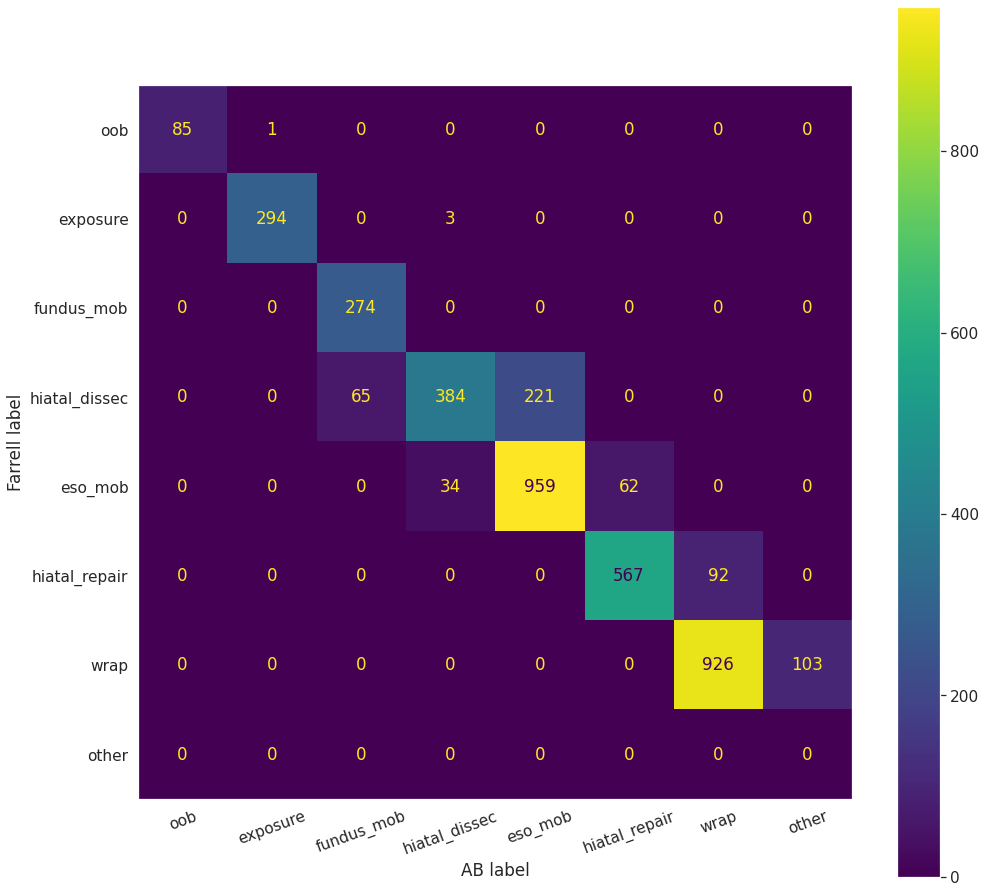

In [191]:
cm = confusion_matrix(ab_frames['phase_gold'], ab_frames['phase'], labels=ab_frames['phase'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ab_frames['phase'].unique())
disp.plot()
#make the plot bigger
fig = plt.gcf()
fig.set_size_inches(16, 16)
#remove the grid
plt.grid(False)
plt.ylabel('Farrell label')
plt.xlabel('AB label')
#make the x ticks 45 degrees
plt.xticks(rotation=20)
plt.show()

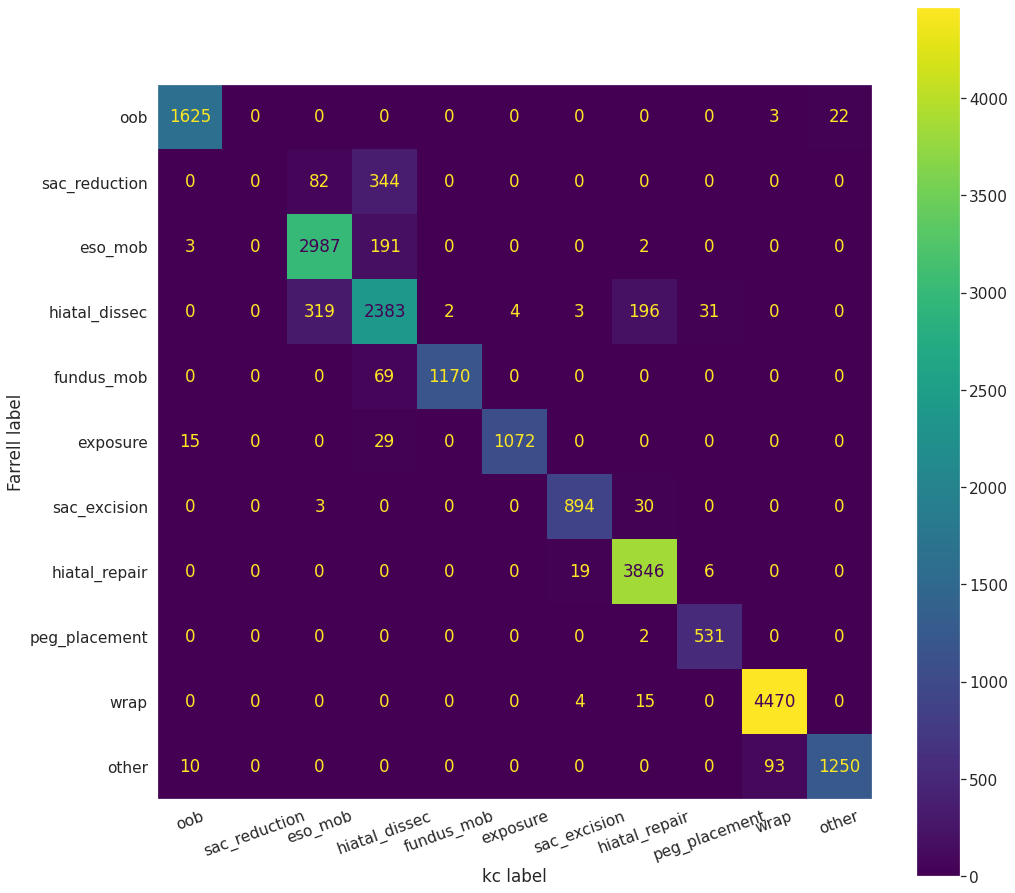

In [192]:
cm = confusion_matrix(kc_frames['phase_gold'], kc_frames['phase'], labels=kc_frames['phase_gold'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kc_frames['phase_gold'].unique())

disp.plot()
#make the plot bigger
fig = plt.gcf()
fig.set_size_inches(16, 16)
#remove the grid
plt.grid(False)
#set the y-axis label to 'Farrel label'
plt.ylabel('Farrell label')
plt.xlabel('kc label')
#make the x ticks 45 degrees
plt.xticks(rotation=20)
plt.show()

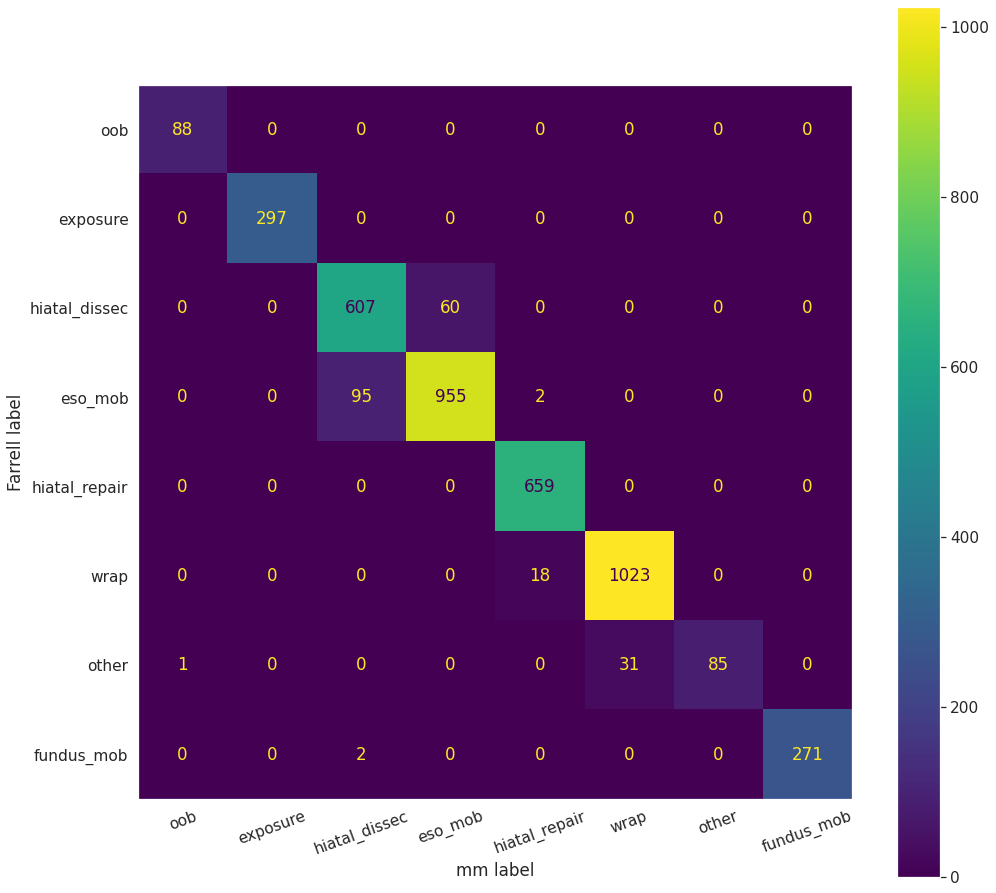

In [193]:
cm = confusion_matrix(mm_frames['phase_gold'], mm_frames['phase'], labels=mm_frames['phase_gold'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mm_frames['phase_gold'].unique())

disp.plot()
#make the plot bigger
fig = plt.gcf()
fig.set_size_inches(16, 16)
#remove the grid
plt.grid(False)
#set the y-axis label to 'Farrel label'
plt.ylabel('Farrell label')
plt.xlabel('mm label')
#make the x ticks 45 degrees
plt.xticks(rotation=20)
plt.show()